# K Means Clustering Example

## 1. Import spark modules

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

In [2]:
spark = SparkSession\
        .builder\
        .appName("PythonPi")\
        .getOrCreate()

**Setup spark configuration and create a spark context**

In [3]:
sc = spark.sparkContext

## 2. Load the data

In [4]:
autoData = sc.textFile("./input/auto-data.csv")

In [5]:
autoData.count()

198

In [6]:
autoData.cache()

./input/auto-data.csv MapPartitionsRDD[1] at textFile at <unknown>:0

**Remove the header**

In [7]:
firstLine = autoData.first()
dataLines = autoData.filter(lambda x: x != firstLine)

In [8]:
dataLines.count()

197

## 3. Clean Data

In [9]:
import math
from pyspark.ml.linalg import Vectors

**A mapping gfunction to transform RDD rows to numeric vector**

In [10]:
def transformToNumeric(inputStr):
    
    attList = inputStr.split(",")
    
    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0
    
    values = Row(DOORS = doors,
                 BODY = float(body),
                 HP = float(attList[7]),
                 RPM = float(attList[8]),
                 MPG = float(attList[9]))
    
    return values

**Transform the RDD using the mapping function**

In [11]:
autoMap = dataLines.map(transformToNumeric)

In [12]:
autoMap.persist()

PythonRDD[5] at RDD at PythonRDD.scala:48

In [13]:
autoMap.collect()

[Row(BODY=2.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=4900.0),
 Row(BODY=2.0, DOORS=1.0, HP=48.0, MPG=47.0, RPM=5100.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=30.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=35.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=60.0, MPG=38.0, RPM=5500.0),
 Row(BODY=1.0, DOORS=1.0, HP=69.0, MPG=31.0, RPM=5200.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=37.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5000.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=2.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=2.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=70.0, MPG=38.0, RPM=5400.0),
 Row(BODY=2.0, DOORS=1.0, HP=62.0, MPG=31.0, RPM=4800.0),
 Row(BODY=2.0, DOORS=1.0, HP=68.0, MPG=31.0, RPM=5500.0),
 Row(BODY=2.0, DOORS=1.0, HP=58.0, MPG=49.0, RPM=4800.0),
 Row(BODY=2.0,

**Create a dataframe using the RDD**

In [14]:
autoDf = spark.createDataFrame(autoMap)

In [15]:
autoDf.show()

+----+-----+----+----+------+
|BODY|DOORS|  HP| MPG|   RPM|
+----+-----+----+----+------+
| 2.0|  1.0|69.0|31.0|4900.0|
| 2.0|  1.0|48.0|47.0|5100.0|
| 2.0|  1.0|68.0|30.0|5000.0|
| 2.0|  1.0|62.0|35.0|4800.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|60.0|38.0|5500.0|
| 1.0|  1.0|69.0|31.0|5200.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|37.0|5500.0|
| 2.0|  1.0|68.0|31.0|5000.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  2.0|68.0|31.0|5500.0|
| 2.0|  1.0|70.0|38.0|5400.0|
| 2.0|  1.0|62.0|31.0|4800.0|
| 2.0|  1.0|68.0|31.0|5500.0|
| 2.0|  1.0|58.0|49.0|4800.0|
| 2.0|  2.0|62.0|31.0|4800.0|
| 2.0|  1.0|76.0|30.0|6000.0|
| 1.0|  2.0|70.0|38.0|5400.0|
+----+-----+----+----+------+
only showing top 20 rows



### Centre and scale the featues

**Print out descriptive statistics**

In [16]:
summStats = autoDf.describe().toPandas()

In [17]:
meanValues = summStats.iloc[1,1:5].values.tolist()
meanValues

['1.532994923857868',
 '1.5685279187817258',
 '103.60406091370558',
 '25.15228426395939']

In [18]:
stdValues = summStats.iloc[2,1:5].values.tolist()
stdValues

['0.5001812579359883',
 '0.49654352778167493',
 '37.639205349518356',
 '6.437862917085915']

**Store the mean and std values in a broadcast variable**

In [19]:
bcMeans = sc.broadcast(meanValues)
bcStdDev = sc.broadcast(stdValues)

**A function for centre and scaling**

In [20]:
def centerAndScale(inRow):
    
    '''a function for scaling'''
    
    global bcMeans
    global bcStdDev
    
    meanArray = bcMeans.value
    stdArray = bcStdDev.value
    
    retArray = []
    # scale each featuer
    for i in range(len(meanArray)):
        retArray.append((float(inRow[i])-float(meanArray[i]))/float(stdArray[i]))
        
    return Vectors.dense(retArray)

**Apply the mapping function**

In [21]:
csAuto = autoDf.rdd.map(centerAndScale)

In [22]:
csAuto.take(10)

[DenseVector([0.9337, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -1.4773, 3.3936]),
 DenseVector([0.9337, -1.145, -0.9459, 0.753]),
 DenseVector([0.9337, -1.145, -1.1053, 1.5297]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -1.1585, 1.9956]),
 DenseVector([-1.0656, -1.145, -0.9194, 0.9083]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 1.8403]),
 DenseVector([0.9337, -1.145, -0.9459, 0.9083])]

**Create a spark dataframe from the features column of RDD**

In [23]:
autoRows=csAuto.map(lambda f:Row(features=f))

In [24]:
autoDF = spark.createDataFrame(autoRows)

In [25]:
autoDF.show()

+--------------------+
|            features|
+--------------------+
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[0.93367168148051...|
|[-1.0656035495158...|
+--------------------+
only showing top 20 rows



## 4. Perform K means clustering

In [26]:
from pyspark.ml.clustering import KMeans

**Create and fit Model**

In [27]:
kmeans = KMeans(k = 3, seed = 1)

In [28]:
model = kmeans.fit(autoDF)

**Compute predictions**

In [29]:
predictions = model.transform(autoDF)

In [30]:
predictions.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[0.93367168148051...|         1|
|[-1.0656035495158...|         0|
+--------------------+----------+
only showing top 20 rows



In [31]:
import pandas as pd

**A map function to convert the data containing dense vector into a tuples of prediction and feature elements**

In [32]:
def unstripData(instr):
    
    return (instr['prediction'],instr["features"][0],instr["features"][1], instr["features"][2],instr["features"][3])

In [33]:
# unstrip the dense vector of the data using the above mapping function
unstripped = predictions.rdd.map(unstripData)

# Collect the data so that we can do a conversion to Pandas DataFrame
predList = unstripped.collect()

# create a pandas DataFrame out of the above data
predPd = pd.DataFrame(predList)

In [34]:
predPd.head()

,0,1,2,3,4
0,1,0.933672,-1.144971,-0.919362,0.908332
1,1,0.933672,-1.144971,-1.477291,3.393629
2,1,0.933672,-1.144971,-0.945930,0.753001
3,1,0.933672,-1.144971,-1.105338,1.529656
4,1,0.933672,-1.144971,-0.945930,1.840318


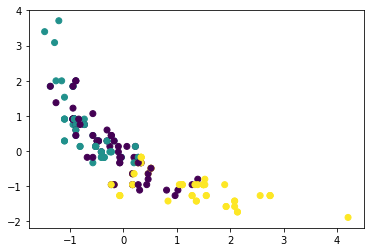

In [35]:
# Import the matplotlib plot library 
import matplotlib.pylab as plt
plt.cla()
##scatter plot for the data
plt.scatter(predPd[3],predPd[4], c = predPd[0])
plt.show()